## 1.데이터 로드 및 데이터 확인 

In [480]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False


orig_data = pd.read_csv("final_con_data1.csv")
orig_data.head()

# 원본 데이터에서 새로 생성한 변수 데이터는 아래와 같다. 
# 1) w/c= water/cement 비율 더미변수 추가 
# 2) age_c = age값이 28일을 기준으로 클래스 값으로 변환
#            age<28일이면 class1, age == 28 이면 class2, age>28이면 class3
# 3) age_f = 28일 기준으로 클래스 분류한것을 숫자 1,2,3으로 재매핑 () 
# 4) age_class1,age_class2,age_class3: age_c를 각각 더미변수화 

# *** 맨끝의 csMPa가 콘크리트 강도값(예측해야할 값) ****

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,w/c,age_c,age_f,age_class_1,age_class_2,age_class_3,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.300000,class_2,2,0,1,0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.300000,class_2,2,0,1,0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,0.685714,class_3,3,0,0,1,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,0.685714,class_3,3,0,0,1,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,0.966767,class_3,3,0,0,1,44.30


In [386]:
data0 = orig_data.copy()
data0.shape

(1030, 15)

In [387]:
data0.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'w/c', 'age_c', 'age_f',
       'age_class_1', 'age_class_2', 'age_class_3', 'csMPa'],
      dtype='object')

In [388]:

#cols = [data.columns[-1]] + [col for col in data if col != data.columns[-1]]
#data = data[cols]
#data.head()


In [389]:
#컬럼명 변경
"""
data.columns = ['cement_component', 'furnace_slag', 'flay_ash',
'water_component', 'superplasticizer', 
'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']
"""

"\ndata.columns = ['cement_component', 'furnace_slag', 'flay_ash',\n'water_component', 'superplasticizer', \n'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']\n"

In [390]:
data0.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,w/c,age_c,age_f,age_class_1,age_class_2,age_class_3,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.300000,class_2,2,0,1,0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.300000,class_2,2,0,1,0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,0.685714,class_3,3,0,0,1,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,0.685714,class_3,3,0,0,1,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,0.966767,class_3,3,0,0,1,44.30


In [391]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 15 columns):
cement              1030 non-null float64
slag                1030 non-null float64
flyash              1030 non-null float64
water               1030 non-null float64
superplasticizer    1030 non-null float64
coarseaggregate     1030 non-null float64
fineaggregate       1030 non-null float64
age                 1030 non-null int64
w/c                 1030 non-null float64
age_c               1030 non-null object
age_f               1030 non-null int64
age_class_1         1030 non-null int64
age_class_2         1030 non-null int64
age_class_3         1030 non-null int64
csMPa               1030 non-null float64
dtypes: float64(9), int64(5), object(1)
memory usage: 120.8+ KB


In [392]:
data0.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.000000,192.375000,272.900000,350.000000,540.000000
slag,1030.0,73.895825,86.279342,0.000000,0.000000,22.000000,142.950000,359.400000
flyash,1030.0,54.188350,63.997004,0.000000,0.000000,0.000000,118.300000,200.100000
water,1030.0,181.567282,21.354219,121.800000,164.900000,185.000000,192.000000,247.000000
superplasticizer,1030.0,6.204660,5.973841,0.000000,0.000000,6.400000,10.200000,32.200000
coarseaggregate,1030.0,972.918932,77.753954,801.000000,932.000000,968.000000,1029.400000,1145.000000
fineaggregate,1030.0,773.580485,80.175980,594.000000,730.950000,779.500000,824.000000,992.600000
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
w/c,1030.0,0.748266,0.314005,0.266893,0.533333,0.675349,0.935165,1.882353
age_f,1030.0,1.958252,0.765640,1.000000,1.000000,2.000000,3.000000,3.000000


In [393]:
data0.isnull().sum() # null data check

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
w/c                 0
age_c               0
age_f               0
age_class_1         0
age_class_2         0
age_class_3         0
csMPa               0
dtype: int64

## 2. 탐색적 데이터 분석 (EDA)

In [394]:
data0.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'w/c', 'age_c', 'age_f',
       'age_class_1', 'age_class_2', 'age_class_3', 'csMPa'],
      dtype='object')

In [395]:
#전체 피처이름들 
feature_name_all = ['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'w/c', 'age_c',
       'age_class_1', 'age_class_2', 'age_class_3', 'csMPa']
feature_name_all_c = ['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'w/c',
       'age_class_1', 'age_class_2', 'age_class_3', 'csMPa']

feature_name_EDA = ['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'w/c','age', 'csMPa']


In [396]:
#탐색적 데이터 분석에 사용할 피처만 골라낸다 
data = data0[feature_name_EDA] 

In [397]:
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,w/c,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,0.300000,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,0.300000,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,0.966767,360,44.30


In [398]:
## 데이터 탐색 (각 변수 데이터의 특성을 살펴보기 위해 데이터 분포를 그래프로 그려보고 데이터 특징을 살펴본다)

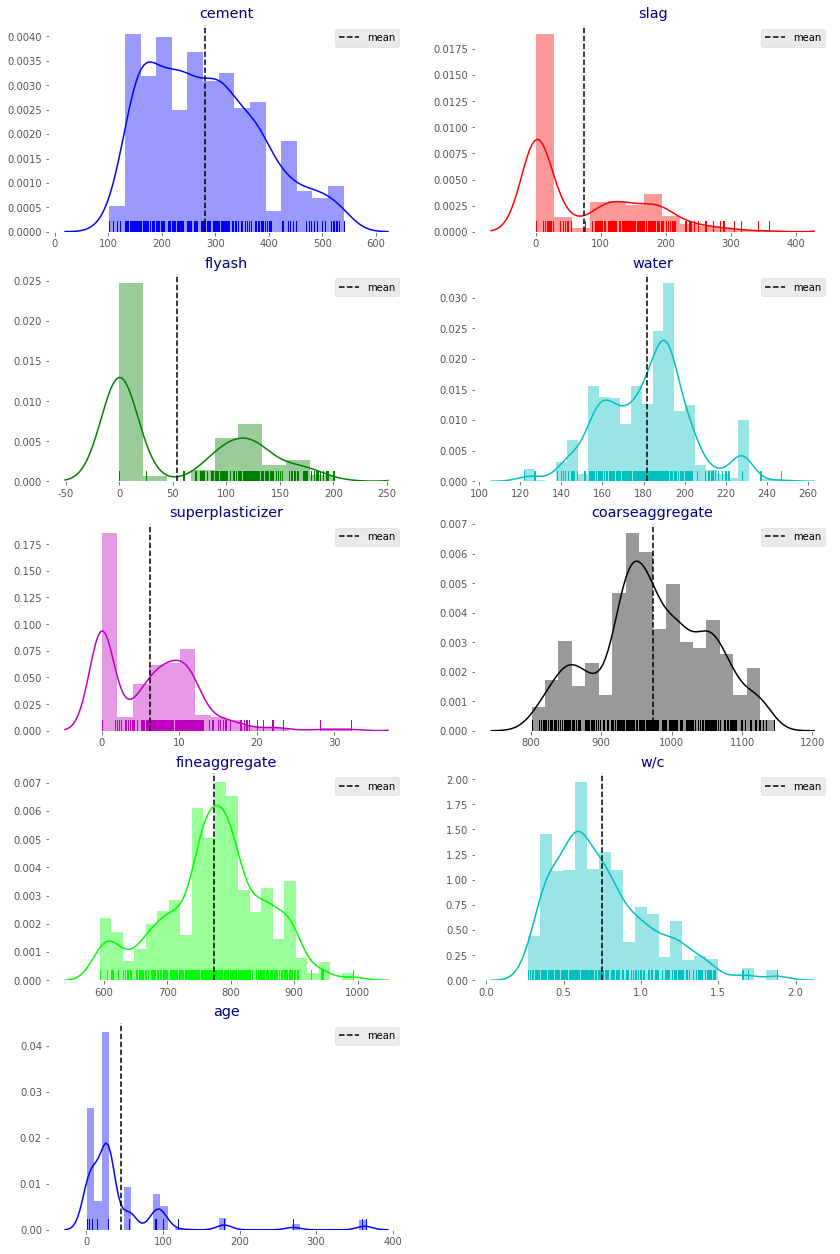

In [399]:
import itertools 
cols = [i for i in data.columns if i not in 'csMPa']
length = len(cols)
cs = ["b","r","g","c","m","k","lime","c","b"]
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.8, wspace=None, hspace=None)

for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(5,2,j+1)
    ax = sns.distplot(data[i],color=k,rug=True)
    ax.set_facecolor("w")
    plt.axvline(data[i].mean(),linestyle="dashed",label="mean",color="k")
    plt.legend(loc="best")
    plt.title(i,color="navy")
    plt.xlabel("")

In [400]:
#예측할 값인 콘크리트 강도 값의 데이터 분포,특징도 살펴본다.

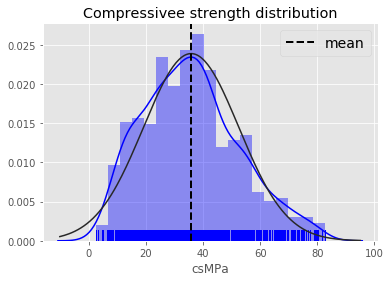

In [401]:
from scipy.stats import norm
from scipy import stats
#plt.figure(figsize=(7,7)) 
#예측하고자 하는 target 변수인 콘크리트 강도 값이 정규 분포 경향을 따르는지 정규분포 곡선과의 fit을 살펴봄 
sns.distplot(data["csMPa"],color="b",rug=True,fit=norm)
plt.axvline(data["csMPa"].mean(),
            linestyle="dashed",color="k",
            label='mean',linewidth=2)
plt.legend(loc="best",prop={"size":14})
plt.title("Compressivee strength distribution")
plt.show()

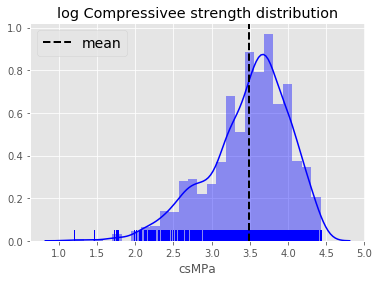

In [39]:
##로그 취해본것-- 딱히 로그 변환 취하지 않아도 될듯
sns.distplot(np.log1p(data["csMPa"]),color="b",rug=True)
plt.axvline(np.log1p(data["csMPa"]).mean(),
            linestyle="dashed",color="k",
            label='mean',linewidth=2)
plt.legend(loc="best",prop={"size":14})
plt.title("log Compressivee strength distribution")
plt.show()

## 3. 변수 상관관계 탐색

In [402]:
feature_name_all0 = ['slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate','w/c', 'age',
       'csMPa']

In [403]:
data=data0[feature_name_all0]

data.head()

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age,csMPa
0,0.0,0.0,2.5,1040.0,676.0,0.300000,28,79.99
1,0.0,0.0,2.5,1055.0,676.0,0.300000,28,61.89
2,142.5,0.0,0.0,932.0,594.0,0.685714,270,40.27
3,142.5,0.0,0.0,932.0,594.0,0.685714,365,41.05
4,132.4,0.0,0.0,978.4,825.5,0.966767,360,44.30


In [404]:
data.shape

(1030, 8)

In [405]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1,
                                                    )

In [406]:
#data['age_f'].astype("category") #데이터 타입 카테고리화 

In [407]:
data[data.columns[:-1]].head()

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age
0,0.0,0.0,2.5,1040.0,676.0,0.300000,28
1,0.0,0.0,2.5,1055.0,676.0,0.300000,28
2,142.5,0.0,0.0,932.0,594.0,0.685714,270
3,142.5,0.0,0.0,932.0,594.0,0.685714,365
4,132.4,0.0,0.0,978.4,825.5,0.966767,360


In [408]:
data[[data.columns[-1]]].mean()

csMPa    35.817961
dtype: float64

In [409]:
y_test.mean()

csMPa    37.458495
dtype: float64

In [410]:
y_train.mean()

csMPa    35.407828
dtype: float64

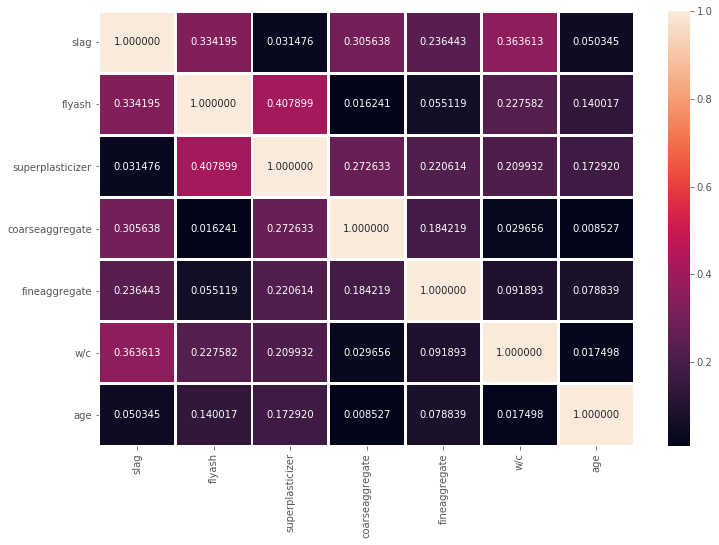

In [411]:
#변수간 상관관계 확인 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(x_train.corr().abs(),linewidth=2,annot=True,fmt="f")
#sns.heatmap(x_train.corr())
plt.show()

In [412]:
from sklearn.ensemble import RandomForestRegressor

rfModel = RandomForestRegressor(n_estimators=100) 
rfModel.fit(X = x_train,y = y_train)
#preds = rfModel.predict(X= X_validate)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [413]:
rfModel.feature_importances_

array([ 0.08033789,  0.01790871,  0.04906596,  0.03030461,  0.03797688,
        0.4170741 ,  0.36733184])

### - 피처 중요도 그래프

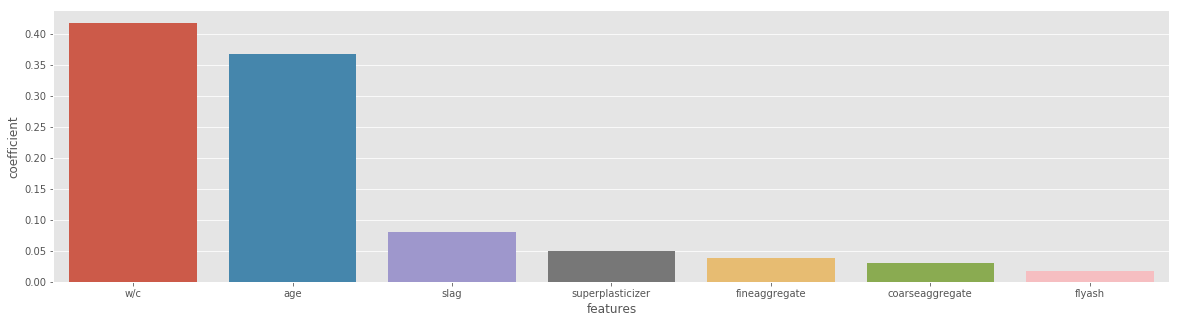

In [414]:
features = pd.DataFrame()
features['features'] = x_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=features,x="features",y="coefficient",ax=ax)

In [51]:
"""
plt.figure(figsize=(12,8))
sns.heatmap(round(data.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt="f")
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.title("Variables summary")
plt.show()
"""

'\nplt.figure(figsize=(12,8))\nsns.heatmap(round(data.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt="f")\nplt.xticks(fontsize=20)\nplt.yticks(fontsize=12)\nplt.title("Variables summary")\nplt.show()\n'

## 4. 4가지 데이터셋 조합 중 최적의 데이터셋 조합 찾기

In [371]:
total_eval=[]

In [434]:
feature_name_all = [ 'cement','water','slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'w/c','csMPa'] # 모든변수 + w/c까지

#### 4가지 데이터셋 변수 조합 ##########################################################################
feature_name_0 = [ 'slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'w/c','age', 'csMPa'] # water,cement 변수제거 & w/c변수 추가
feature_name_1 = [ 'cement','water','slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'] # w/c 변수제거 (water,cement유지)
feature_name_2 = [ 'slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate','w/c','age_class_1', 'age_class_2', 'age_class_3', 'csMPa'] 
       #water,cement 변수제거 , w/c변수 추가 ,  age_class 더미 
feature_name_3 = [ 'cement','water','slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age_class_1', 'age_class_2', 'age_class_3', 'csMPa'] 
       # w/c 변수제거 (water,cement유지), age_class 더미 
 #전체 테스트 해본결과 변수 조합은 트리계열의 경우 스케일링을 하지않고 전체 변수 + w/c변수 추가한 경우 성능이 제일 낫다 

In [435]:
data=data0[feature_name_3]
data.head()

,cement,water,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,age_class_1,age_class_2,age_class_3,csMPa
0,540.0,162.0,0.0,0.0,2.5,1040.0,676.0,0,1,0,79.99
1,540.0,162.0,0.0,0.0,2.5,1055.0,676.0,0,1,0,61.89
2,332.5,228.0,142.5,0.0,0.0,932.0,594.0,0,0,1,40.27
3,332.5,228.0,142.5,0.0,0.0,932.0,594.0,0,0,1,41.05
4,198.6,192.0,132.4,0.0,0.0,978.4,825.5,0,0,1,44.30


In [436]:
data.shape

(1030, 11)

In [437]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1,
                                                    )

In [438]:
x_train.head()

,cement,water,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,age_class_1,age_class_2,age_class_3
612,277.0,191.0,0.0,0.0,0.0,968.0,856.0,0,1,0
525,359.0,154.0,19.0,141.0,10.9,942.0,801.0,1,0,0
597,272.8,185.7,181.9,0.0,0.0,1012.4,714.3,0,1,0
846,366.0,191.0,187.0,0.0,7.0,824.0,757.0,0,1,0
259,212.6,159.4,0.0,100.4,10.4,1003.8,903.8,1,0,0


In [439]:
x_train.shape

(824, 10)

In [440]:
"""
#Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train),
                              columns = x_train.columns)
x_train_scaled.head()
"""

'\n#Scaling the features\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler().fit(x_train)\nx_train_scaled = pd.DataFrame(scaler.transform(x_train),\n                              columns = x_train.columns)\nx_train_scaled.head()\n'

In [441]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
Model = []
RMSE = []
R_sq = []
cv = KFold(5, random_state = 1)
#feaure_import=[]

#cross validation scores for each algorithm test 
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())
    #feaure_import.append(model.feature_importances_)
    

In [442]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor)
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

names = ['Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','ExtraTrees Regressor','BaggingRegressor']
models = [DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),ExtraTreesRegressor(),BaggingRegressor()]

#Running all algorithms
for name, model in zip(names, models): 
        input_scores(name, model,x_train, y_train)# x_train_scaled, y_train)
    # x_train값은 스케일링을 하면, 스케일링 하지 않을때보다 각 모델별 성능이 RMSE기준 0.01~0.07정도 더 안좋게 나왔으므로 
    # 스케일링 하지 않은 x_train을 사용한다.

In [443]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation.sort_values(['RMSE'])#, ascending=[False])


FOLLOWING ARE THE TRAINING SCORES: 


,Model,R Squared,RMSE
2,Gradient Boosting Regressor,0.862122,6.191657
1,Random Forest Regressor,0.821114,6.828824
5,BaggingRegressor,0.832458,7.040477
4,ExtraTrees Regressor,0.817208,7.162150
3,Adaboost Regressor,0.766169,8.198521
0,Decision Tree Regressor,0.735695,8.640785


In [802]:
total_eval.append(evaluation.sort_values(['RMSE']))

In [803]:
total_eval ## 변수 조합별 돌려본 성능 결과 

[                         Model  R Squared      RMSE
 4         ExtraTrees Regressor   0.898608  5.141349
 2  Gradient Boosting Regressor   0.902847  5.225575
 5             BaggingRegressor   0.893286  5.423512
 1      Random Forest Regressor   0.902969  5.441455
 0      Decision Tree Regressor   0.855102  6.548298
 3           Adaboost Regressor   0.793616  7.524368,
                          Model  R Squared      RMSE
 2  Gradient Boosting Regressor   0.904085  5.181127
 4         ExtraTrees Regressor   0.898763  5.218455
 1      Random Forest Regressor   0.894950  5.624525
 5             BaggingRegressor   0.884956  5.761297
 0      Decision Tree Regressor   0.786385  7.660017
 3           Adaboost Regressor   0.779200  7.757861,
                          Model  R Squared      RMSE
 2  Gradient Boosting Regressor   0.862960  6.210748
 5             BaggingRegressor   0.833124  6.546227
 1      Random Forest Regressor   0.835840  6.620728
 4         ExtraTrees Regressor   0.817998  

In [805]:
## 성능평가 모아서 데이터 프래임으로 변환 
eval_frame = pd.concat([total_eval[0],total_eval[1],total_eval[2],total_eval[3]], 
                       keys=[ 'feature_name0','feature_name1','feature_name2','feature_name3'])

### 데이터셋:  트리계열 데이터 최적의 조합은 feature_name0 

feature_name_0 = [ 'slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'w/c','age', 'csMPa'] <br> -> water,cement 변수제거 w/c추가,age(연속형)

In [806]:
eval_frame

Model  R Squared      RMSE
feature_name0 4         ExtraTrees Regressor   0.898608  5.141349
              2  Gradient Boosting Regressor   0.902847  5.225575
              5             BaggingRegressor   0.893286  5.423512
              1      Random Forest Regressor   0.902969  5.441455
              0      Decision Tree Regressor   0.855102  6.548298
              3           Adaboost Regressor   0.793616  7.524368
feature_name1 2  Gradient Boosting Regressor   0.904085  5.181127
              4         ExtraTrees Regressor   0.898763  5.218455
              1      Random Forest Regressor   0.894950  5.624525
              5             BaggingRegressor   0.884956  5.761297
              0      Decision Tree Regressor   0.786385  7.660017
              3           Adaboost Regressor   0.779200  7.757861
feature_name2 2  Gradient Boosting Regressor   0.862960  6.210748
              5             BaggingRegressor   0.833124  6.546227
              1      Random Forest Regressor   0.835840  6.620728
              4         ExtraTrees Regressor   0.817998  7.140397
              0      Decision Tree Regressor   0.785969  7.763961
              3           Adaboost Regressor   0.779488  7.872169
feature_name3 2  Gradient Boosting Regressor   0.862894  6.193610
              1      Random Forest Regressor   0.832100  7.015346
              4         ExtraTrees Regressor   0.816879  7.019174
              5             BaggingRegressor   0.822999  7.036916
              3           Adaboost Regressor   0.774340  8.059115
              0      Decision Tree Regressor   0.731285  8.730819

In [808]:
"""
## 엑셀 파일로 저장하기
from pandas import ExcelWriter
from pandas import ExcelFile
writer = ExcelWriter('var_compare_final.xlsx')
eval_frame.to_excel(writer,'Sheet1')
writer.save()
"""

#### --------------------------------------------------------------------------------------------------

## 5. 모델별 베스트 파라미터 찾기:  6가지 트리계열 모델 파라미터 튜닝작업
#### 5번 과정을 통해 찾은 베스트 파라미터 값은 아래 6번에 "best_pram_model"에 따로 저장해 두었다.<br>5번과정을 돌리는데 시간이 오래 걸리므로 6번으로 넘어가면 됨 

최적의 데이터셋 조합을 정했으면,테스트 진행해볼 모델
(gradient boosting, random forest,extra tree,decision tree,ada boost,bagging(교수님께서 추가로 더 돌려보라고 해서 추가한 모델)6개
를 각각 그리드서치로 파라미터 튜닝 작업을 진행한다.

In [58]:
# 데이터 준비 

In [444]:
#### 트리계열 모델을 돌리기위한 최적의 변수데이터 조합(# water,cement 변수제거 & w/c변수 추가)을 이용하여 6가지 트리계열 모델 파라미터 튜닝
feature_name_0 = [ 'slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'w/c','age', 'csMPa'] # water,cement 변수제거 & w/c변수 추가
data=data0[feature_name_0]
data.head()

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age,csMPa
0,0.0,0.0,2.5,1040.0,676.0,0.300000,28,79.99
1,0.0,0.0,2.5,1055.0,676.0,0.300000,28,61.89
2,142.5,0.0,0.0,932.0,594.0,0.685714,270,40.27
3,142.5,0.0,0.0,932.0,594.0,0.685714,365,41.05
4,132.4,0.0,0.0,978.4,825.5,0.966767,360,44.30


In [90]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1,
                                                    )

In [91]:
x_train.head(3)

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age
612,0.0,0.0,0.0,968.0,856.0,0.689531,28
525,19.0,141.0,10.9,942.0,801.0,0.428969,3
597,181.9,0.0,0.0,1012.4,714.3,0.680718,28


## 그레디언트 부스팅 튜닝 

In [62]:
from sklearn.metrics import make_scorer
#rmse = np.sqrt(mse)
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))
    # Creating root mean square error for sklearns crossvalidation
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [63]:
#tuning this base model-디폴트 튜닝값을 확인 
GradientBoostingRegressor()

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
cv = KFold(5, random_state = 1) # 5 kfold 

## tuning for number of trees & max_depth
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,1001,10), 
              'max_depth':range(2,16,2)}
              #'min_samples_split':[100], #range(200,1001,200), 
              #'learning_rate':[0.2]}
clf = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', 
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_) ### 트리개수 최적의 파라미터 n_estimators=600,max_depth=4

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=600, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
R Squared: 0.930339072351


In [76]:
## tuning the tree specific parameters
param_grid = {'n_estimators': [600],
              'max_depth': [4], 
              'min_samples_split': range(50,501,10), 
              'learning_rate':[0.01, 0.1, 0.2, 0.3]}
tuned_GBR = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                   param_grid = param_grid, scoring='r2', 
                   cv=cv).fit(x_train, y_train)
print(tuned_GBR.best_estimator_) #최적의 파라미터 
print("R Squared:",tuned_GBR.best_score_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=180, min_weight_fraction_leaf=0.0,
             n_estimators=600, n_iter_no_change=None, presort='auto',
             random_state=1, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
R Squared: 0.937539847269


In [77]:
#그레디언트 부스팅 최적의 파라미터:   n_estimators=600, learning_rate=0.2,min_samples_split=180, max_depth=4

## 랜덤포레스트 튜닝

In [92]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [93]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(50,300,10)}
              #'max_depth':[10], #range(5,16,2), 
              #'min_samples_split':[50], #range(200,1001,200), 
              #'min_samples_leaf':[2]}
clf = GridSearchCV(RandomForestRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', 
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_) ### 트리개수 최적의 파라미터 290

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
R Squared: 0.910429061211


In [105]:
## tuning the tree specific parameters
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[290],
              'max_depth':range(25,50,2),#range(25,50,2)
              'min_samples_split':range(2,21,2), #range(200,1001,200), 
              'min_samples_leaf':[1, 2, 5, 10]}
tuned_RF = GridSearchCV(RandomForestRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', 
                   cv=cv).fit(x_train, y_train)

In [106]:
print(tuned_RF.best_estimator_) 
print("R Squared:",tuned_RF.best_score_) ### 트리개수 최적의 파라미터 290개 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
R Squared: 0.910429061211


In [103]:
#랜덤 포레스트 최적의 파라미터:   n_estimators=290,min_samples_leaf=1,min_samples_split=2, max_depth=25

## ExtraTrees Regressor 튜닝

In [270]:
ExtraTreesRegressor()

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(1,300,10)}
             
              #'max_depth':range(10,31,2), #range(5,16,2), 
              #'min_samples_split':[50], #range(200,1001,200), 
              #'min_samples_leaf':[2]}

clf = GridSearchCV(ExtraTreesRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_)

In [127]:
param_grid = {'n_estimators':[221],
             'max_depth':range(1,25,1)}
              #'max_depth':range(10,31,2), #range(5,16,2), 
              #'min_samples_split':[50], #range(200,1001,200), 
              #'min_samples_leaf':[2]}
clf = GridSearchCV(ExtraTreesRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_) ### 트리개수 최적의 파라미터 221개, max_depth=14

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False)
R Squared: 0.911453748557


In [129]:
## tuning the tree specific parameters
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[221],
              'max_depth':[14], #range(5,16,2), 
              'min_samples_split':range(2,501,10), #range(200,1001,200), 
              'min_samples_leaf':[1,2,5,10]}
tuned_EXT = GridSearchCV(ExtraTreesRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(tuned_EXT.best_estimator_) 
print("R Squared:",tuned_EXT.best_score_) ### 트리개수 최적의 파라미터 230개 

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False)
R Squared: 0.911453748557


#최종 best 하이퍼 파라미터 : ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
          oob_score=False, random_state=1, verbose=0, warm_start=False)
R Squared: 0.911453748557

## DecisionTreeRegressor 튜닝

In [139]:
from sklearn.model_selection import GridSearchCV
param_grid = {
              'max_depth':range(5,25,2), 
              'min_samples_split':range(2,50,1), #range(200,1001,200), 
              'min_samples_leaf':[1,2,5,10]}
tuned_DT = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', 
                   cv=cv).fit(x_train, y_train)
print(tuned_DT.best_estimator_) 
print("R Squared:",tuned_DT.best_score_) 

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R Squared: 0.856282952875


Decision Tree best 값:<br>
DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R Squared: 0.856282952875

## AdaBoostRegressor 튜닝

In [143]:
AdaBoostRegressor()

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [142]:
#tuning for number of trees
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(20,300,10),
              #'max_depth':[10], #range(5,16,2), 
              #'min_samples_split':[100], #range(200,1001,200), 
             'learning_rate':[0.01, 0.1, 0.2, 0.3,0.4,0.6,0.8]}
clf = GridSearchCV(AdaBoostRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_) ### 트리개수 최적의 파라미터 240개  0.802030265603

AdaBoostRegressor(base_estimator=None, learning_rate=0.8, loss='linear',
         n_estimators=60, random_state=1)
R Squared: 0.800537050291


In [147]:
tuned_ADA =clf 
print(tuned_ADA.best_estimator_)
print("R Squared:",tuned_ADA.best_score_) 

AdaBoostRegressor(base_estimator=None, learning_rate=0.8, loss='linear',
         n_estimators=60, random_state=1)
R Squared: 0.800537050291


AdaBoostRegressor 베스트 값:  <br> 
AdaBoostRegressor(base_estimator=None, learning_rate=0.8, loss='linear',
         n_estimators=60, random_state=1)

## BaggingRegressor 튜닝 (교수님께서 추가로 더 돌려보라고 피드백 주셨던 모델)

In [40]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=200, max_samples=20,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [549]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(50,350,10)
              }
              #'max_features':[2], #range(200,1001,200), 
              #'min_samples_leaf':[1]}
tuned_BAG = GridSearchCV(BaggingRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(tuned_BAG.best_estimator_)
print("R Squared:",tuned_BAG.best_score_) 

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=320, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)
R Squared: 0.910083658694


In [382]:
"""
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':range(50,250,10),
              'max_samples':range(2,25,2),
               'max_features':[5,6,7]}
              #'max_features':[2], #range(200,1001,200), 
              #'min_samples_leaf':[1]}
clf = GridSearchCV(BaggingRegressor(random_state=1), 
                   param_grid = param_grid, scoring= 'r2', #scoring = 'r2'
                   cv=cv).fit(x_train, y_train)
print(clf.best_estimator_) 
print("R Squared:",clf.best_score_) ### 0.842217845718
"""

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=7, max_samples=24,
         n_estimators=70, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)
R Squared: 0.706399909287


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
         verbose=0, warm_start=False)
R Squared: 0.909752910286

## 6. Test set에  베스트 파라미터 모델 적용 

### 0) 저장된 베스트 파라미터 

In [453]:
##베스트 파라미터 값 모델 따로 저장 
best_pram_model = [DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=4, min_weight_fraction_leaf=0.0,
                   presort=False, random_state=1, splitter='best'),

                   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=None,
                   oob_score=False, random_state=1, verbose=0, warm_start=False),

                  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                  learning_rate=0.2, loss='ls', max_depth=4, max_features=None,
                  max_leaf_nodes=None, min_impurity_decrease=0.0,
                  min_impurity_split=None, min_samples_leaf=1,
                  min_samples_split=180, min_weight_fraction_leaf=0.0,
                  n_estimators=600, n_iter_no_change=None, presort='auto',
                  random_state=1, subsample=1.0, tol=0.0001,
                  validation_fraction=0.1, verbose=0, warm_start=False),

                  AdaBoostRegressor(base_estimator=None, learning_rate=0.8, loss='linear',
                  n_estimators=60, random_state=1),

                  ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
                  max_features='auto', max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
                  oob_score=False, random_state=1, verbose=0, warm_start=False),

                  BaggingRegressor(base_estimator=None, bootstrap=True,
                 bootstrap_features=False, max_features=1.0, max_samples=1.0,
                 n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
                 verbose=0, warm_start=False)]

model_name = ["clf_DT", "clf_RF","clf_GBR","clf_ADA","clf_EXT","clf_BAG" ]

for name, model in zip(model_name, best_pram_model): 
    globals()[name] = model.fit(x_train, y_train)

### 1) 데이터 
#### 전체 데이터 나눈 20%인 테스트 데이터 셋 사용 

In [490]:
#### 트리계열 모델을 돌리기위한 최적의 변수데이터 조합(# water,cement 변수제거 & w/c변수 추가)을 이용하여 6가지 트리계열 모델 파라미터 튜닝
feature_name_0 = [ 'slag', 'flyash', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'w/c','age', 'csMPa'] # water,cement 변수제거 & w/c변수 추가
data=data0[feature_name_0]
data.head()

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age,csMPa
0,0.0,0.0,2.5,1040.0,676.0,0.300000,28,79.99
1,0.0,0.0,2.5,1055.0,676.0,0.300000,28,61.89
2,142.5,0.0,0.0,932.0,594.0,0.685714,270,40.27
3,142.5,0.0,0.0,932.0,594.0,0.685714,365,41.05
4,132.4,0.0,0.0,978.4,825.5,0.966767,360,44.30


In [491]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[data.columns[:-1]],
                                                    data[[data.columns[-1]]],
                                                    test_size = .2,
                                                    random_state = 1,
                                                    )

In [492]:
x_train.head()

,slag,flyash,superplasticizer,coarseaggregate,fineaggregate,w/c,age
612,0.0,0.0,0.0,968.0,856.0,0.689531,28
525,19.0,141.0,10.9,942.0,801.0,0.428969,3
597,181.9,0.0,0.0,1012.4,714.3,0.680718,28
846,187.0,0.0,7.0,824.0,757.0,0.521858,28
259,0.0,100.4,10.4,1003.8,903.8,0.749765,3


#### 1) Grandient boosting with test data set 

In [458]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#clf_GBR = tuned_GBR.best_estimator_.fit(x_train, y_train)
y_train_pred = clf_GBR.predict(x_train)
y_test_pred = clf_GBR.predict(x_test)



print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred))) # MSE가 작을수록

print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))



R^2 train: 0.988, test: 0.921
RMSE train: 1.819, test: 4.526


디폴트로 돌렸을때(하이퍼 파라미터 없이)
RMSE train: 4.770, test: 6.075
R^2 train: 0.919, test: 0.858

#### 2) Random forest with test data set

In [463]:

#clf_RF = tuned_RF.best_estimator_.fit(x_train, y_train)
y_train_pred = clf_RF.predict(x_train)
y_test_pred = clf_RF.predict(x_test)

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

R^2 train: 0.985, test: 0.896
RMSE train: 2.035, test: 5.204


#랜덤포레스트 기본으로 돌린결과 :R^2 train: 0.979, test: 0.878 RMSE train: 2.441, test: 5.644

#### 3) Extra tree  with test data set

In [464]:
#clf_EXT =tuned_EXT.best_estimator_.fit(x_train, y_train)
y_train_pred =clf_EXT.predict(x_train)
y_test_pred = clf_EXT.predict(x_test)

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

R^2 train: 0.995, test: 0.895
RMSE train: 1.199, test: 5.242


Extra tree 기본으로 돌린것
MSE train: 9.935, test: 59.521
R^2 train: 0.965, test: 0.772
RMSE train: 3.152, test: 7.715

#### 4)Decision Tree with test data set

In [465]:
#clf_DT = tuned_DT.best_estimator_.fit(x_train, y_train)
y_train_pred = clf_DT.predict(x_train)
y_test_pred = clf_DT.predict(x_test)

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

R^2 train: 0.990, test: 0.845
RMSE train: 1.701, test: 6.362


디폴트 : 
MSE train: 9.935, test: 71.078
R^2 train: 0.965, test: 0.727
RMSE train: 3.152, test: 8.431

In [52]:
#Decision 트리의 경우 학습데이터 셋에 과적합- 테스트 셋에 성능 매우 떨어짐 

#### 5)AdaBoostRegressor with test data set

In [ ]:
models = [DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),ExtraTreesRegressor(),BaggingRegressor()]

In [469]:

#clf_ADA = tuned_ADA.best_estimator_.fit(x_train, y_train)
y_train_pred =clf_ADA.predict(x_train)
y_test_pred = clf_ADA.predict(x_test)

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

R^2 train: 0.824, test: 0.761
RMSE train: 7.046, test: 7.900


디폴트:
R^2 train: 0.818, test: 0.768
RMSE train: 7.167, test: 7.775

#### 6) Bagging Regressor with test data set

In [472]:

#clf_BAG = tuned_BAG.best_estimator_.fit(x_train, y_train)
y_train_pred =clf_BAG.predict(x_train)
y_test_pred = clf_BAG.predict(x_test)

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print('RMSE train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

R^2 train: 0.985, test: 0.896
RMSE train: 2.066, test: 5.219


디폴트:R^2 train: 0.980, test: 0.888
RMSE train: 2.403, test: 5.409

## 7-1 ) 베스트 파라미터 적용된 모델로 그래프 그리기--------------

In [493]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

Model = []
RMSE = []
R_sq = []
cv = KFold(5, random_state = 1)

def input_scores_bestparam(name, model, X, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, X, y, cv=cv, 
                                               scoring='neg_mean_squared_error')))
    R_sq.append(cross_val_score(model, X, y, cv=cv, scoring='r2'))
    


In [494]:
y_train_raveled = np.ravel(y_train)
#y_train_raveled

In [495]:
names = ['Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','ExtraTrees Regressor','Bagging Regressor'] 
models = [best_pram_model[0], best_pram_model[1], best_pram_model[2], 
          best_pram_model[3], best_pram_model[4], best_pram_model[5] ] #tuned_BAG.best_estimator_

#Running all algorithms
for name, model in zip(names, models): 
    input_scores_bestparam(name, model,x_train, y_train)

In [496]:
#RMSE mean_계산 
RMSE_mean=[]
for i in range(len(RMSE)):
    RMSE_mean.append(np.mean(RMSE[i]))

In [497]:
RMSE_mean

[6.3224530385295195,
 5.0071062801813495,
 4.1644154013815555,
 7.4697570284561339,
 4.9813200173230214,
 5.0271341035210879]

In [498]:
#R_squared mean_계산 
R_sq_mean=[]
for i in range(len(R_sq )):
    R_sq_mean.append(np.mean(R_sq[i]))

In [499]:
R_sq_mean

[0.8562467901426063,
 0.91041541331692477,
 0.93752247103267461,
 0.80051927902839037,
 0.91142937305873151,
 0.90973987616012963]

In [500]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R-Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,R-Squared,RMSE
0,Decision Tree Regressor,"[0.874865889115, 0.881056895317, 0.80911373625...","[5.69466218808, 5.99127308986, 7.14522161638, ..."
1,Random Forest Regressor,"[0.907406761263, 0.915988974377, 0.89768668169...","[4.89857484488, 5.0352104152, 5.23111719475, 4..."
2,Gradient Boosting Regressor,"[0.952179232001, 0.941913350919, 0.91470174275...","[3.52037058636, 4.1868523172, 4.77637529888, 3..."
3,Adaboost Regressor,"[0.782938625981, 0.834083377616, 0.78948709749...","[7.50017478396, 7.07610762232, 7.50356630126, ..."
4,ExtraTrees Regressor,"[0.903866420283, 0.921849440221, 0.91682058349...","[4.99134590119, 4.85641203977, 4.71667876843, ..."
5,Bagging Regressor,"[0.905816151105, 0.915971038621, 0.89856108681...","[4.94047069447, 5.0357478773, 5.20871575815, 4..."


In [501]:
evaluation_mean=pd.DataFrame({'Model': Model,
                           'RMSE': RMSE_mean,
                           'R-Squared': R_sq_mean})
print("[MEAN]FOLLOWING ARE THE TRAINING SCORES: ")
evaluation_mean

[MEAN]FOLLOWING ARE THE TRAINING SCORES: 


,Model,R-Squared,RMSE
0,Decision Tree Regressor,0.856247,6.322453
1,Random Forest Regressor,0.910415,5.007106
2,Gradient Boosting Regressor,0.937522,4.164415
3,Adaboost Regressor,0.800519,7.469757
4,ExtraTrees Regressor,0.911429,4.981320
5,Bagging Regressor,0.909740,5.027134


In [502]:
## 엑셀 파일로 저장하기
writer = ExcelWriter('best_param_mean.xlsx')
evaluation_mean.to_excel(writer,'Sheet1')
writer.save()

In [503]:
a=[evaluation.loc[i,'RMSE'] for i in range(0,6)]
aa=[evaluation.loc[i,'R-Squared'] for i in range(0,6)]

In [504]:
b = pd.DataFrame(a, columns=['Fold_'+str(i) for i in range(1,6)]) #RMSE
bb = pd.DataFrame(aa, columns=['Fold_'+str(i) for i in range(1,6)]) #'R-Squared'

In [505]:
bb['model']=['1.Decision Tree Regressor', 
             '2.Random Forest Regressor', '3.Gradient Boosting Regressor',
             '4.Adaboost Regressor','5.ExtraTrees Regressor','6.Bagging Regressor']

In [506]:
feature_name_0 = ['model','Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']

In [507]:
bb[feature_name_0]

,model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
0,1.Decision Tree Regressor,0.874866,0.881057,0.809114,0.889749,0.826449
1,2.Random Forest Regressor,0.907407,0.915989,0.897687,0.931825,0.899170
2,3.Gradient Boosting Regressor,0.952179,0.941913,0.914702,0.955614,0.923204
3,4.Adaboost Regressor,0.782939,0.834083,0.789487,0.810212,0.785876
4,5.ExtraTrees Regressor,0.903866,0.921849,0.916821,0.923266,0.891344
5,6.Bagging Regressor,0.905816,0.915971,0.898561,0.929351,0.899000


In [508]:
b['model']=['1.Decision Tree Regressor', 
         '2.Random Forest Regressor', '3.Gradient Boosting Regressor',
         '4.Adaboost Regressor','5.ExtraTrees Regressor','6.Bagging Regressor']
b[feature_name_0]

,model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
0,1.Decision Tree Regressor,5.694662,5.991273,7.145222,5.327307,7.453802
1,2.Random Forest Regressor,4.898575,5.035210,5.231117,4.189172,5.681457
2,3.Gradient Boosting Regressor,3.520371,4.186852,4.776375,3.380189,4.958290
3,4.Adaboost Regressor,7.500175,7.076108,7.503566,6.989575,8.279361
4,5.ExtraTrees Regressor,4.991346,4.856412,4.716679,4.444353,5.897811
5,6.Bagging Regressor,4.940471,5.035748,5.208716,4.264497,5.686239


In [509]:
## c = evaluation['Model'].ravel()
c = ['1.Decision Tree Regressor', 
         '2.Random Forest Regressor', '3.Gradient Boosting Regressor',
         '4.Adaboost Regressor','5.ExtraTrees Regressor','6.Bagging Regressor']


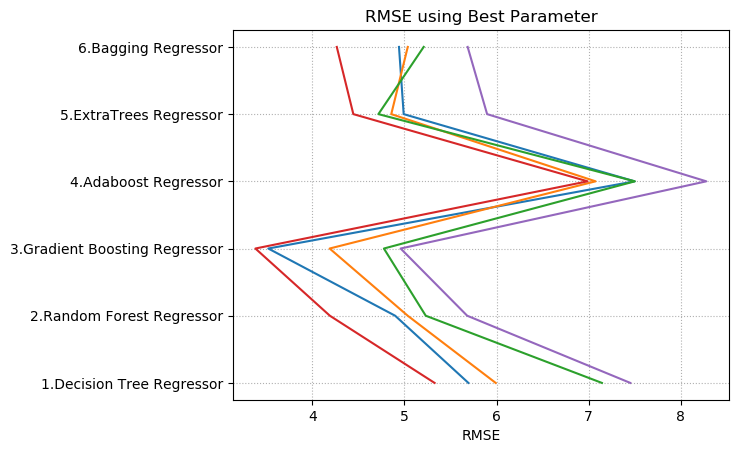

In [510]:
mpl.rcdefaults()
for i in range(1,6):
    plt.plot(b['Fold_'+str(i)],c)
    #print(b['Fold_'+str(i)], c)
plt.xlabel('RMSE')
plt.grid(linestyle=':')
plt.title('RMSE using Best Parameter')
plt.show()

Text(0.5,1,'R-Squared using Best Parameter')

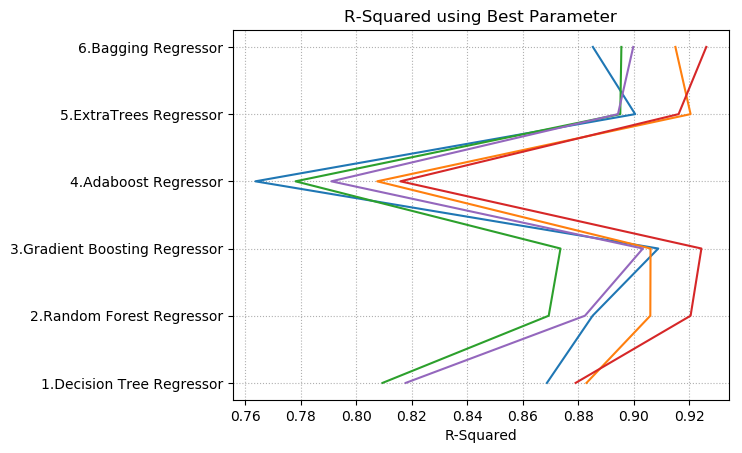

In [175]:
mpl.rcdefaults()
for i in range(1,6):
    plt.plot(bb['Fold_'+str(i)], c)
plt.xlabel('R-Squared')
plt.grid(linestyle=':')
plt.title('R-Squared using Best Parameter')

##  7-2 )디폴트 모델로 돌려봤을때( 베스트 파라미터 모델 그래프와 비교를 위해 생성) 

In [522]:
Model = []
RMSE = []
R_sq = []
cv = KFold(5, random_state = 1)

def input_scores_defaultparam(name, model, X, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, X, y, cv=cv, 
                                               scoring='neg_mean_squared_error')))
    R_sq.append(cross_val_score(model, X, y, cv=cv, scoring='r2'))

In [523]:
y_train_raveled = np.ravel(y_train)
#y_train_raveled

In [524]:


names = ['Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','ExtraTrees Regressor','Bagging Regressor']
models = [DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),ExtraTreesRegressor(),BaggingRegressor()]

#Running all algorithms
for name, model in zip(names, models): 
    input_scores_defaultparam(name, model,x_train, y_train)# x_train_scaled, y_train)

In [525]:
evaluation_def = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'R-Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation_def 

FOLLOWING ARE THE TRAINING SCORES: 


,Model,R-Squared,RMSE
0,Decision Tree Regressor,"[0.87473310758, 0.882969699918, 0.814473876684...","[5.89719825618, 6.2626317926, 7.2958335661, 5...."
1,Random Forest Regressor,"[0.896425010714, 0.907610242915, 0.88419104117...","[5.12574063803, 5.45686653048, 5.96045458238, ..."
2,Gradient Boosting Regressor,"[0.908502485996, 0.906123468089, 0.87363732393...","[4.87619045212, 5.32265878187, 5.81641029211, ..."
3,Adaboost Regressor,"[0.759048946068, 0.826589549587, 0.79838133359...","[7.77071969308, 7.33634914293, 7.67393894148, ..."
4,ExtraTrees Regressor,"[0.905399233892, 0.922191618318, 0.89938435845...","[5.64853506498, 5.07856225538, 5.32924577812, ..."
5,Bagging Regressor,"[0.881974788239, 0.906861947136, 0.88819284472...","[5.39681336352, 5.21065852808, 5.91114021892, ..."


In [526]:
#RMSE mean_계산 
RMSE_mean=[]
for i in range(len(RMSE)):
    RMSE_mean.append(np.mean(RMSE[i]))

#R_squared mean_계산 
R_sq_mean=[]
for i in range(len(R_sq )):
    R_sq_mean.append(np.mean(R_sq[i]))    

In [527]:
evaluation_def_mean=pd.DataFrame({'Model': Model,
                           'RMSE': RMSE_mean,
                           'R-Squared': R_sq_mean})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation_def_mean

FOLLOWING ARE THE TRAINING SCORES: 


,Model,R-Squared,RMSE
0,Decision Tree Regressor,0.853929,6.529343
1,Random Forest Regressor,0.895361,5.397687
2,Gradient Boosting Regressor,0.902964,5.205937
3,Adaboost Regressor,0.797309,7.618249
4,ExtraTrees Regressor,0.904946,5.462433
5,Bagging Regressor,0.896164,5.420776


In [174]:
## 엑셀 파일로 저장하기
from pandas import ExcelWriter
from pandas import ExcelFile
writer = ExcelWriter('default_param_mean.xlsx')
evaluation_mean.to_excel(writer,'Sheet1')
writer.save()

In [528]:
a=[evaluation.loc[i,'RMSE'] for i in range(0,6)]
aa=[evaluation.loc[i,'R-Squared'] for i in range(0,6)]

In [529]:
b = pd.DataFrame(a, columns=['Fold_'+str(i) for i in range(1,6)]) #RMSE
bb = pd.DataFrame(aa, columns=['Fold_'+str(i) for i in range(1,6)]) #'R-Squared'

In [530]:
b['model']=['1.Decision Tree Regressor', 
         '2.Random Forest Regressor', '3.Gradient Boosting Regressor',
         '4.Adaboost Regressor','5.ExtraTrees Regressor','6.Bagging Regressor']

In [531]:
feature_name_0 = ['model','Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']

In [532]:
b[feature_name_0]

,model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
0,1.Decision Tree Regressor,5.694662,5.991273,7.145222,5.327307,7.453802
1,2.Random Forest Regressor,4.898575,5.035210,5.231117,4.189172,5.681457
2,3.Gradient Boosting Regressor,3.520371,4.186852,4.776375,3.380189,4.958290
3,4.Adaboost Regressor,7.500175,7.076108,7.503566,6.989575,8.279361
4,5.ExtraTrees Regressor,4.991346,4.856412,4.716679,4.444353,5.897811
5,6.Bagging Regressor,4.940471,5.035748,5.208716,4.264497,5.686239


In [533]:
c = ['1.Decision Tree Regressor', 
         '2.Random Forest Regressor', '3.Gradient Boosting Regressor',
         '4.Adaboost Regressor','5.ExtraTrees Regressor','6.Bagging Regressor']

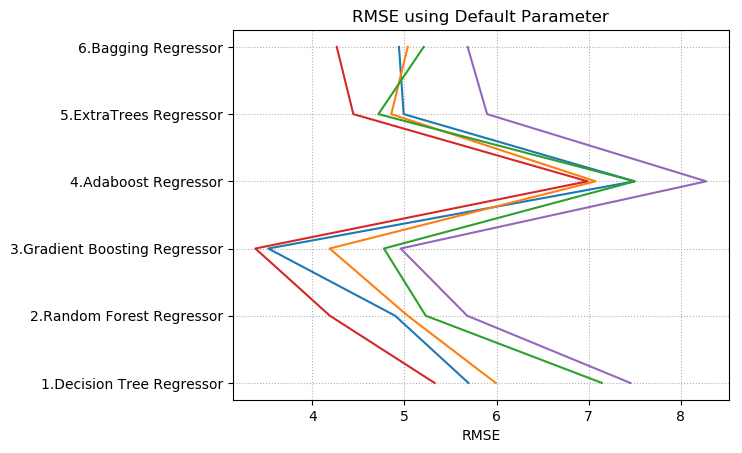

In [534]:
mpl.rcdefaults()
for i in range(1,6):
    plt.plot(b['Fold_'+str(i)],c)
plt.xlabel('RMSE')
plt.grid(linestyle=':')
plt.title('RMSE using Default Parameter')
plt.show()

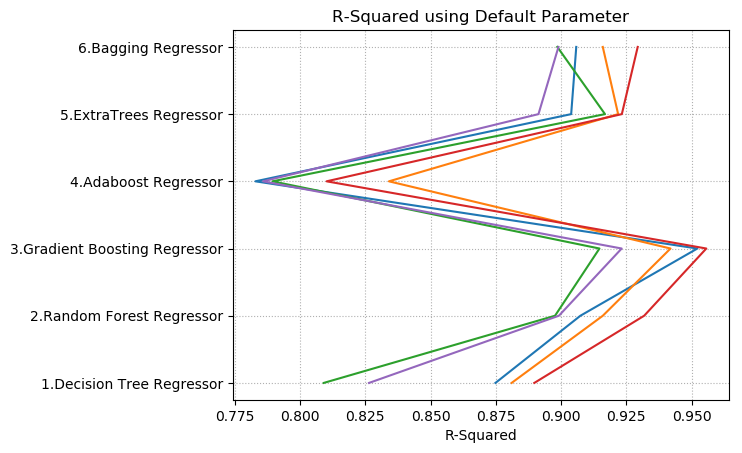

In [535]:
mpl.rcdefaults()
for i in range(1,6):
    plt.plot(bb['Fold_'+str(i)], c)
plt.xlabel('R-Squared')
plt.grid(linestyle=':')
plt.title('R-Squared using Default Parameter')
plt.show()

## 7-3)  TEST SET에 베스트 파라미터 모델 적용 최종 그래프 

In [178]:
##베스트 파라미터 값 모델 따로 저장 
best_pram_model = [DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=4, min_weight_fraction_leaf=0.0,
                   presort=False, random_state=1, splitter='best'),

                   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=2,
                   min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=None,
                   oob_score=False, random_state=1, verbose=0, warm_start=False),

                  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                  learning_rate=0.2, loss='ls', max_depth=4, max_features=None,
                  max_leaf_nodes=None, min_impurity_decrease=0.0,
                  min_impurity_split=None, min_samples_leaf=1,
                  min_samples_split=180, min_weight_fraction_leaf=0.0,
                  n_estimators=600, n_iter_no_change=None, presort='auto',
                  random_state=1, subsample=1.0, tol=0.0001,
                  validation_fraction=0.1, verbose=0, warm_start=False),

                  AdaBoostRegressor(base_estimator=None, learning_rate=0.8, loss='linear',
                  n_estimators=60, random_state=1),

                  ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=14,
                  max_features='auto', max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=221, n_jobs=None,
                  oob_score=False, random_state=1, verbose=0, warm_start=False),

                  BaggingRegressor(base_estimator=None, bootstrap=True,
                 bootstrap_features=False, max_features=1.0, max_samples=1.0,
                 n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
                 verbose=0, warm_start=False)]

model_name = ["clf_DT", "clf_RF","clf_GBR","clf_ADA","clf_EXT","clf_BAG" ]

for name, model in zip(model_name, best_pram_model): 
    globals()[name] = model.fit(x_train, y_train)

In [536]:
final_e= np.array([
    np.sqrt(mean_squared_error(y_test, clf_DT.predict(x_test))),
    np.sqrt(mean_squared_error(y_test, clf_RF.predict(x_test))),
    np.sqrt(mean_squared_error(y_test, clf_GBR.predict(x_test))),
    np.sqrt(mean_squared_error(y_test, clf_ADA.predict(x_test))),
    np.sqrt(mean_squared_error(y_test, clf_EXT.predict(x_test))),
    np.sqrt(mean_squared_error(y_test, clf_BAG.predict(x_test)))
   ])
final_e.reshape(-1,1)

array([[ 6.36195615],
       [ 5.2040732 ],
       [ 4.52571588],
       [ 7.90030356],
       [ 5.24213307],
       [ 5.2192017 ]])

In [537]:
final_r = np.array([
    r2_score(y_test, clf_DT.predict(x_test)),
    r2_score(y_test, clf_RF.predict(x_test)),
    r2_score(y_test, clf_GBR.predict(x_test)),
    r2_score(y_test, clf_ADA.predict(x_test)),
    r2_score(y_test, clf_EXT.predict(x_test)),
    r2_score(y_test, clf_BAG.predict(x_test)),
   ])
final_r

array([ 0.84474366,  0.89611453,  0.92143257,  0.76058268,  0.89458945,
        0.89550966])

In [538]:
RMSE_final = pd.DataFrame(final_e, columns = ['RMSE'],
                      index=['1.Decision Tree\nRegressor', 
         '2.Random Forest\nRegressor', '3.Gradient Boosting\nRegressor',
         '4.Adaboost\nRegressor','5.ExtraTrees\nRegressor','6.Bagging\nRegressor'])
RMSE_final

,RMSE
1.Decision Tree\nRegressor,6.361956
2.Random Forest\nRegressor,5.204073
3.Gradient Boosting\nRegressor,4.525716
4.Adaboost\nRegressor,7.900304
5.ExtraTrees\nRegressor,5.242133
6.Bagging\nRegressor,5.219202


In [539]:
R_Squared_final = pd.DataFrame(final_r, columns = ['R-Squared'],
                           index=['1.Decision Tree\nRegressor', 
         '2.Random Forest\nRegressor', '3.Gradient Boosting\nRegressor',
         '4.Adaboost\nRegressor','5.ExtraTrees\nRegressor','6.Bagging\nRegressor'])
R_Squared_final

,R-Squared
1.Decision Tree\nRegressor,0.844744
2.Random Forest\nRegressor,0.896115
3.Gradient Boosting\nRegressor,0.921433
4.Adaboost\nRegressor,0.760583
5.ExtraTrees\nRegressor,0.894589
6.Bagging\nRegressor,0.895510


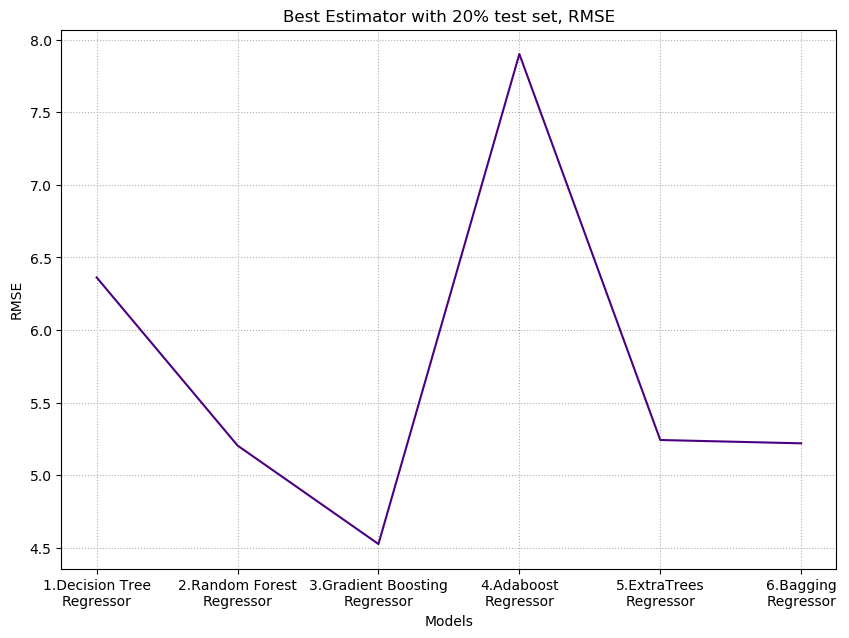

In [540]:
plt.figure(figsize=(10,7))
plt.plot(RMSE_final, color='indigo')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.grid(linestyle=':')
plt.title('Best Estimator with 20% test set, RMSE')
plt.show()

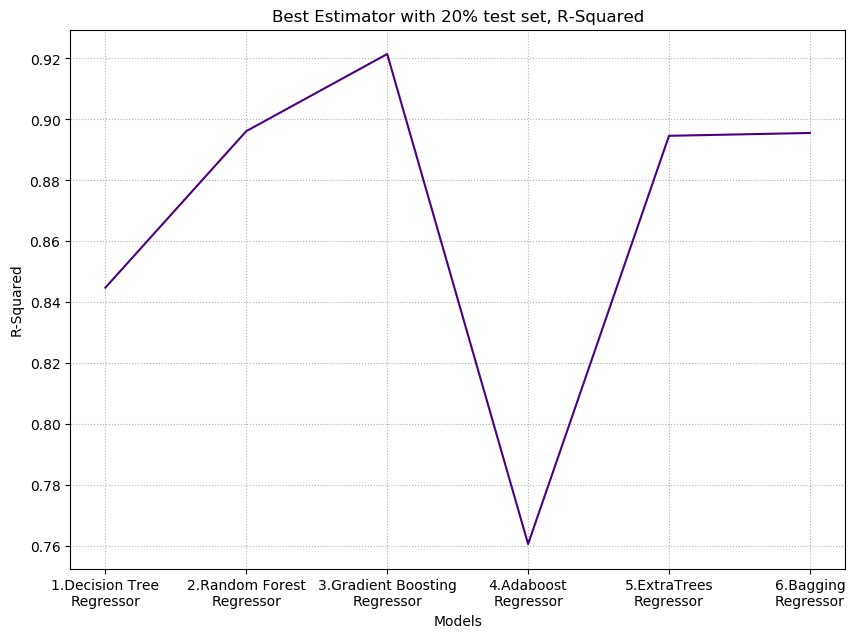

In [541]:
plt.figure(figsize=(10,7))
plt.plot(R_Squared_final, color='indigo')
plt.xlabel('Models')
plt.ylabel('R-Squared')
plt.grid(linestyle=':')
plt.title('Best Estimator with 20% test set, R-Squared')
plt.show()

In [542]:
final_df=pd.concat([RMSE_final, R_Squared_final], axis=1)
final_df

,RMSE,R-Squared
1.Decision Tree\nRegressor,6.361956,0.844744
2.Random Forest\nRegressor,5.204073,0.896115
3.Gradient Boosting\nRegressor,4.525716,0.921433
4.Adaboost\nRegressor,7.900304,0.760583
5.ExtraTrees\nRegressor,5.242133,0.894589
6.Bagging\nRegressor,5.219202,0.895510


In [194]:
## 엑셀 파일로 저장하기
writer = ExcelWriter('[TREE]Final_test_mean.xlsx')
final_df.to_excel(writer,'Sheet1')
writer.save()